In [2]:
from imports import *

2024-06-18 13:48:54.209697: I tensorflow/core/util/port.cc:111] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-06-18 13:48:54.234368: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9342] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-06-18 13:48:54.234391: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-06-18 13:48:54.234406: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1518] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-06-18 13:48:54.238593: I tensorflow/core/platform/cpu_feature_g

In [3]:
data = pd.read_csv('data/15min1h4h/EURUSD15.csv', sep='\t')
data = data[(int(data.shape[0]/2)):]
data.columns = ['time', 'open', 'high', 'low', 'close', 'volume']
#original_data = data.copy()

In [4]:
pip_factor = 10000

In [5]:
sys.path.append('src')
from process_data import DataProcessor
from vanilla_transformer import Transformer
from visualize_data import Visualizer
from train_model import ModelTrainer
model_trainer = ModelTrainer()
data_processor = DataProcessor()
visualizer = Visualizer()

In [6]:
def find_last_row_input_sequence(input_sequences, input_seq_idx, target):
    time_tmp = input_sequences[input_seq_idx][-1][0]  # time of last candle in input sequence
    return target[target['time'] == time_tmp].index[0]

def rcst_candles(pred, target, idx, pred_candles, output_seq_len):
    # open_tmp = target.loc[idx][1]
    # high_tmp = target.loc[idx][2]
    # low_tmp = target.loc[idx][3]
    close_tmp = target.loc[idx][1]
    for i in range(output_seq_len):
        # open_tmp += pred[0][i][0].numpy()
        # high_tmp += pred[0][i][1].numpy()
        # low_tmp += pred[0][i][2].numpy()
        close_tmp += pred[0][i][0].numpy()
        #pred_candles.loc[len(pred_candles)] = ['', open_tmp, high_tmp, low_tmp, close_tmp]
        pred_candles.loc[len(pred_candles)] = ['', close_tmp, 420]
    return pred_candles

In [7]:
def apply_butterworth(data, order, cutoff_freq):
    sampling_rate = 1  # one every one minute
    nyquist_freq = 0.5 * sampling_rate
    normalized_cutoff_freq = cutoff_freq / nyquist_freq
    b, a = butter(order, normalized_cutoff_freq, btype='low', analog=False)
    y = filtfilt(b, a, data)
    return y

In [8]:
def create_four_predictions(target_idx, model, input_seq, idx0, idx1, idx2, idx3):
    pred0 = model(input_seq[idx0:idx0+1, :, :], None, training=False)
    pred1 = model(input_seq[idx1:idx1+1, :, :], None, training=False)
    pred2 = model(input_seq[idx2:idx2+1, :, :], None, training=False)
    pred3 = model(input_seq[idx3:idx3+1, :, :], None, training=False)
    return pred0, pred1, pred2, pred3

In [9]:
input_seq_len = 64
output_seq_len = 16

train_pct = 0.6
val_pct = 0.2

In [10]:
data['bw_open'] = apply_butterworth(data['open'], 5, 1/16)  # 8 minutes
data['bw_high'] = apply_butterworth(data['high'], 5, 1/16)  # 8 minutes
data['bw_low'] = apply_butterworth(data['low'], 5, 1/16)  # 8 minutes
data['bw_close'] = apply_butterworth(data['close'], 5, 1/16)  # 8 minutes

In [11]:
#data['rsi_close_7'] = abstract.RSI(data, timeperiod=7, price='bw_close')
data['rsi_close_14'] = abstract.RSI(data, timeperiod=7, price='bw_close')
#data['willr_close_12'] = abstract.WILLR(data, timeperiod=12, price='bw_close')
data['willr_close_42'] = abstract.WILLR(data, timeperiod=42, price='bw_close')

In [12]:
data.dropna(how='any', axis=0, inplace=True)

In [13]:
data, _ = data_processor.normalize_custom(data, train_pct, ['volume', 'rsi_close_14', 'willr_close_42', 'bw_open', 'bw_high', 'bw_low', 'bw_close'])

In [14]:
target_time = data[['time', 'bw_close', 'close']]

In [15]:
target = data[['close', 'bw_close']]

In [16]:
data.drop(['open', 'high', 'low', 'close'], axis=1, inplace=True)

In [17]:
Xdata, ydata = model_trainer.create_Xy_data(data, target, input_seq_len, output_seq_len)

In [18]:
Xtrain_time, ytrain_c, Xval_time, yval_c, Xtest_time, ytest_c = model_trainer.split_data(Xdata, ydata, train_pct, val_pct)

In [19]:
Xtrain = (Xtrain_time[:, :, 1:]).astype(np.float64)
Xval = (Xval_time[:, :, 1:]).astype(np.float64)
Xtest = (Xtest_time[:, :, 1:]).astype(np.float64)

ytrain = ytrain_c[:, :, 1:]
yval = yval_c[:, :, 1:]
ytest = ytest_c[:, :, 1:]

In [20]:
config = {
    'input_seq_len': input_seq_len,
    'output_seq_len': output_seq_len,
    'multihead_attn_heads': 4,
    'd_k': 32,
    'd_v': 32,
    'd_ff': 32,
    'd_out': ytrain.shape[-1],
    'd_model': 32,
    'encoder_layers': 1,
    'decoder_layers': 1,
    'dropout_rate': 0.1,
    'activation': 'relu',
    'batch_size': 32,
}

In [21]:
epochs = 15
path = 'saved_models/tf-nonstat-15m.h5'

#model = model_trainer.load_model_transformer(path, Xtest, config)

model = Transformer(config)

2024-06-18 13:49:03.100749: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:894] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-06-18 13:49:03.105942: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:894] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-06-18 13:49:03.106080: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:894] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysf

In [22]:
model, best_epoch, train_losses, val_losses = model_trainer.train_model_transformer(Xtrain, ytrain, Xval, yval, path, epochs, model, 1e-3, config, Xtest)

<class 'numpy.ndarray'> <class 'numpy.ndarray'> <class 'numpy.ndarray'> <class 'numpy.ndarray'> <class 'str'> <class 'int'> <class 'vanilla_transformer.Transformer'> <class 'float'> <class 'dict'> <class 'numpy.ndarray'>


2024-06-18 13:49:07.995725: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x55bcb1325670 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2024-06-18 13:49:07.995745: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA GeForce RTX 3060, Compute Capability 8.6
2024-06-18 13:49:07.998865: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2024-06-18 13:49:08.030151: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:442] Loaded cuDNN version 8904
2024-06-18 13:49:08.083767: I ./tensorflow/compiler/jit/device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


Epoch: 0, Loss: 0.021153411509633527, Val Loss: 0.10350342958740259, Val loss improved
Epoch: 1, Loss: 0.00362068489800019, Val Loss: 0.10913238897021561
Epoch: 2, Loss: 0.0035830979531533786, Val Loss: 0.1079300090853871
Epoch: 3, Loss: 0.0035698707703346842, Val Loss: 0.10372364579382677
Epoch: 4, Loss: 0.0035839111421933547, Val Loss: 0.09185674931751145, Val loss improved
Epoch: 5, Loss: 0.00389234980112874, Val Loss: 0.08073433172060598, Val loss improved
Epoch: 6, Loss: 0.004218421967646448, Val Loss: 0.0738436849975583, Val loss improved
Epoch: 7, Loss: 0.0044869339990358985, Val Loss: 0.07843924294089022
Epoch: 8, Loss: 0.0045951138190848135, Val Loss: 0.06792600675879995, Val loss improved
Epoch: 9, Loss: 0.004760462989524889, Val Loss: 0.08031898457587487
Epoch: 10, Loss: 0.004863748405861819, Val Loss: 0.0868707074613732
Epoch: 11, Loss: 0.004826625472762618, Val Loss: 0.11446704565938415
Epoch: 12, Loss: 0.004918231098303831, Val Loss: 0.07673646725980347
Epoch: 13, Loss: 0

In [23]:
close_idx = 0
idx0 = 5000
idx1 = 2000
idx2 = 7500
idx3 = 8000
pred0, pred1, pred2, pred3 = create_four_predictions(close_idx, model, Xtest, idx0, idx1, idx2, idx3)

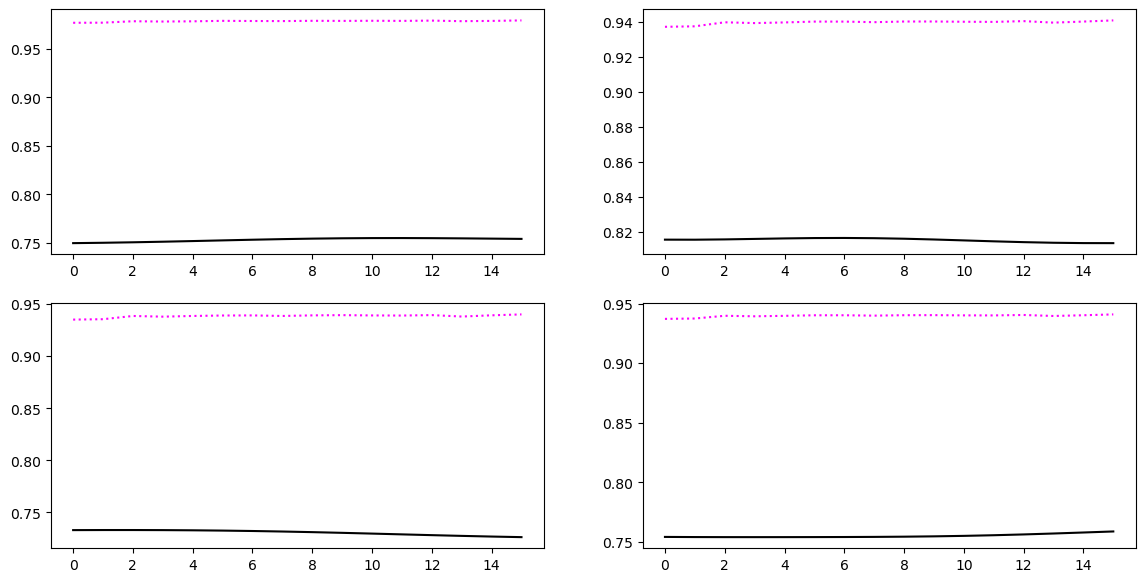

In [24]:
visualizer.plot_four_predictions([pred0, pred1, pred2, pred3], ytest, idx0, idx1, idx2, idx3, close_idx)

In [25]:
pred = model(Xtest, target=None, training=False)

In [26]:
last_closes_input_seqs = list(Xtest[:, -1, 4])
last_closes_output_seqs = list(ytest[:, -1, 0])
last_closes_pred_seqs = list(pred[:, -1, 0])

In [27]:
real_price_movement = [a-b for a, b in zip(last_closes_output_seqs, last_closes_input_seqs)]
pred_price_movement = [a-b for a, b in zip(last_closes_pred_seqs, last_closes_input_seqs)]
# element < 0 --> price go down

In [28]:
real_classes = data_processor.create_binary_classification_classes(real_price_movement)
pred_classes = data_processor.create_binary_classification_classes(pred_price_movement)

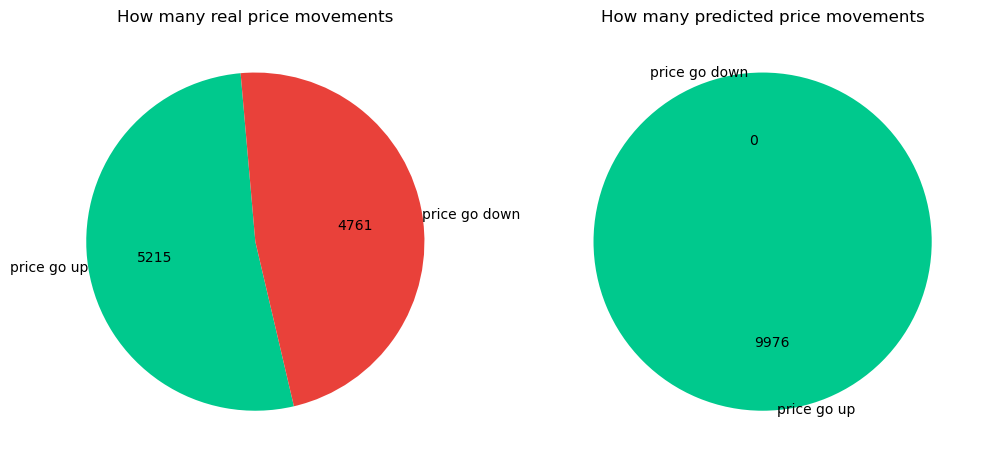

In [29]:
visualizer.pie_number_of_price_movements_binary(real_classes, pred_classes)